# Brain Tumor Detection

Introduction:
----------------
This notebook focuses on the task of brain tumor detection using deep learning techniques. Brain tumors are abnormal growths of cells in the brain that can cause severe health issues. Early detection plays a crucial role in providing timely medical intervention and improving patient outcomes. Deep learning algorithms have shown promising results in automating the process of brain tumor detection from medical images.

In this notebook, we will explore a dataset of brain MRI images containing both tumor and non-tumor samples. We will develop a deep learning model to classify these images and distinguish between the presence and absence of brain tumors. The model will be trained on a subset of the data and evaluated on a separate test set to assess its performance.

Dataset Overview:
---- 
The Brain Tumor Detection dataset from Kaggle consists of brain MRI images collected for the purpose of brain tumor detection. The dataset has been split into three subsets: the train set, the validation set, and the test set.

In the upcoming sections, we will explore the dataset in more detail, visualize sample images from both classes, and analyze the class distribution to better understand the characteristics of the brain tumor dataset. This analysis will serve as the foundation for subsequent data preprocessing, model development, and evaluation stages of our brain tumor detection pipeline.


### Import needed modules

In [1]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
from typing import List
from time import perf_counter
from tensorflow.keras.applications.resnet50 import ResNet50


# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print ('modules loaded')

modules loaded


In [58]:
class Config:
    # Set the data directory
    data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
    seed = 42
    input_size = (224, 224)
    epochs = 40
    weights = 'imagenet'
    learning_rate= 0.001
    
    generator_args = {
        #'preprocessing_function': tf.keras.applications.mobilenet_v2.preprocess_input,
        'class_mode': 'categorical',
        'batch_size': 8,
        'seed': 42,
        'target_size':(224, 224),
        'color_mode': 'rgb'
    }
    
    # Define augmentation arguments
    augmentation_args = {
        'rotation_range': 30,
        'zoom_range': 0.15,
        'width_shift_range': 0.2,
        'height_shift_range': 0.2,
        'shear_range': 0.15,
        'horizontal_flip': True,
        'fill_mode': 'nearest'
    }
    
    

### Data Preprocessing

In [3]:
def generate_data_paths_labels(data_dir):
    """
    Generates file paths and labels for the data in the specified directory.

    Args:
        data_dir: The directory path where the data is located.

    Returns:
        filepaths (List[str]): A list of file paths for the data files.
        labels (List[str]): A list of corresponding labels for the data files.

    """
    filepaths = []
    labels = []

    # Get the list of subdirectories in the data directory
    folds = os.listdir(data_dir)[:2]

    # Iterate over the subdirectories
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)

        # Iterate over the files in each subdirectory
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels



In [59]:
# Generate data paths and labels
filepaths, labels = generate_data_paths_labels(Config.data_dir)

# Split the data into train, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    filepaths,
    labels,
    test_size=0.2,
    stratify=labels,
    shuffle=True,
    random_state=Config.seed,
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    shuffle=True,
    random_state=Config.seed,
)

# Print the sizes of each split
print("Train set size:", len(train_paths))
print("Validation set size:", len(val_paths))
print("Test set size:", len(test_paths))

Train set size: 161
Validation set size: 41
Test set size: 51


In [5]:
def create_image_dataframe(filepaths: List[str]):
    """
    Creates a DataFrame with filepaths and corresponding labels.

    Args:
        filepaths (List[str]): A list of filepaths.

    Returns:
        pd.DataFrame: A DataFrame containing the filepaths and labels
    """

    labels = [pathlib.Path(filepath).parent.name for filepath in filepaths]

    filepath_series = pd.Series(filepaths, name="Filepath").astype(str)
    labels_series = pd.Series(labels, name="Label")

    # Concatenate filepaths and labels
    df = pd.concat([filepath_series, labels_series], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1, random_state=Config.seed).reset_index(drop=True)

    return df

In [60]:
train_df = create_image_dataframe(train_paths)
val_df = create_image_dataframe(val_paths)
# Combine train_df and val_df
test_df = create_image_dataframe(test_paths)


print(f"Number of pictures in the training set: {train_df.shape[0]}")
print(f"Number of pictures in the test set: {test_df.shape[0]}")
print(f"Number of pictures in the validation set: {val_df.shape[0]}\n")


print(f"Number of different labels: {len(train_df.Label.unique())}\n")
print(f"Labels: {train_df.Label.unique()}")

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures in the training set: 161
Number of pictures in the test set: 51
Number of pictures in the validation set: 41

Number of different labels: 2

Labels: ['yes' 'no']


,Filepath,Label
0,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
1,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
4,/kaggle/input/brain-mri-images-for-brain-tumor...,yes


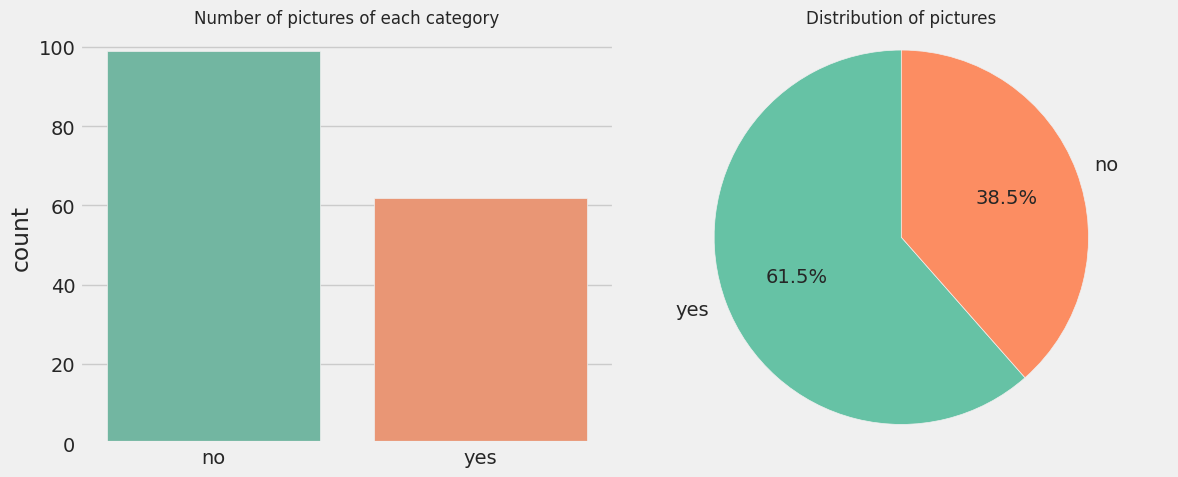

In [51]:

def plot_category_distribution(df, save_path=None):
    """Plots and saves a bar plot and a pie chart for the category distribution in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the category data.
        save_path (str): The directory to save the generated images.
    """

    # Display the number of pictures of each category in the DataFrame
    vc = df['Label'].value_counts()

    # Plotting the bar chart
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(x=sorted(vc.index), y=vc, palette="Set2")
    plt.title("Number of pictures of each category", fontsize=12)

    # Plotting the pie chart
    plt.subplot(1, 2, 2)
    plt.pie(vc, labels=vc.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
    plt.title("Distribution of pictures", fontsize=12)
    plt.axis('equal')
    if save_path is not None:
        # Saving the pie chart
        pie_chart_path = os.path.join(save_path, 'category_distribution_pie.png')
        plt.savefig(pie_chart_path)
        
        # Saving the bar plot
        bar_plot_path = os.path.join(save_path, 'category_distribution_bar.png')
        plt.savefig(bar_plot_path)

    plt.tight_layout()
    plt.show()


plot_category_distribution(train_df, save_path='/kaggle/working' )

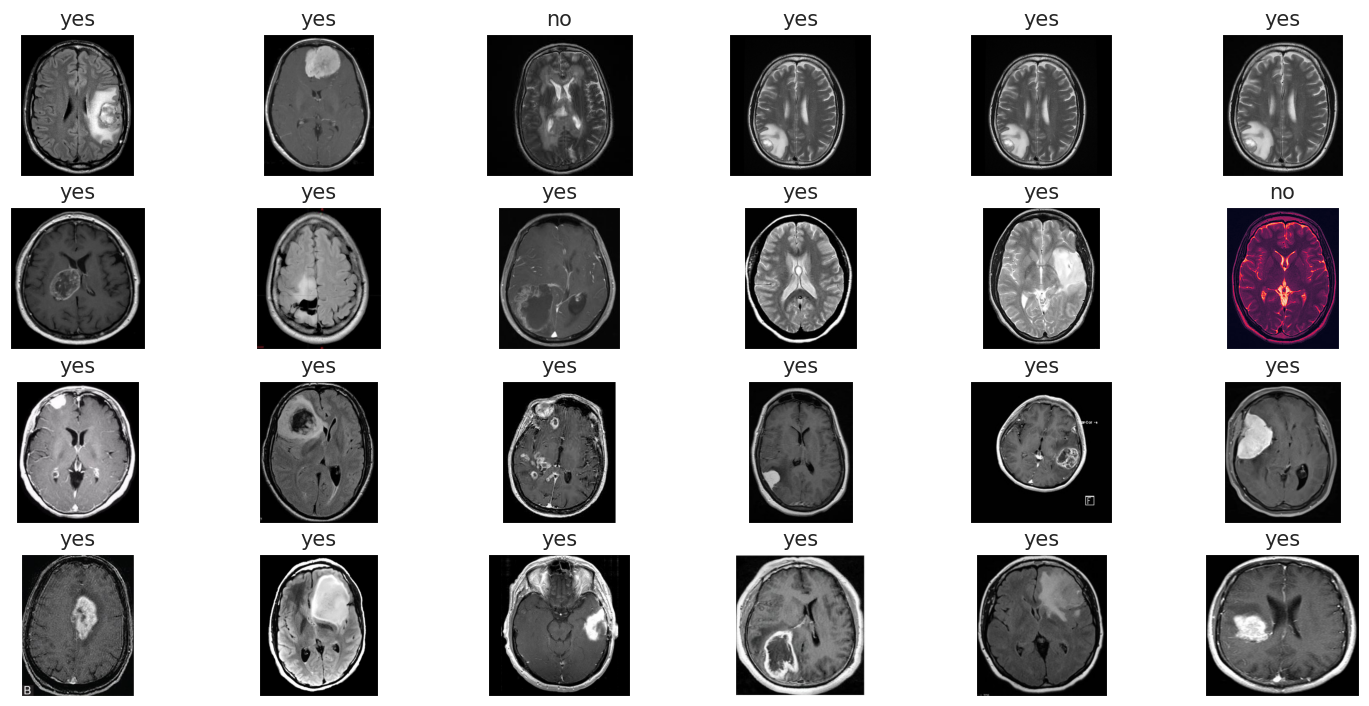

In [9]:
def display_images(df, nrows, ncols, figsize, save_path=None):
    """Displays images from the dataset on subplots and saves the generated image if save_path is provided.

    Args:
        df (pd.DataFrame): The DataFrame containing the image filepaths and labels.
        nrows (int): The number of rows of subplots.
        ncols (int): The number of columns of subplots.
        figsize (tuple): The figure size (width, height) in inches.
        save_path (str, optional): The directory to save the generated image. Defaults to None.
    """

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df.Filepath[i]))
        ax.set_title(df.Label[i], fontsize=15)

    plt.tight_layout(pad=0.5)

    # Saving the generated image if save_path is provided
    if save_path is not None:
        save_file_path = os.path.join(save_path, 'image_display.png')
        plt.savefig(save_file_path)

    plt.show()


display_images(train_df, nrows=4, ncols=6, figsize=(15, 7), save_path='/kaggle/working')

### Create image data generator

In [52]:
def create_gen():
    """
    Create image data generators for training, validation, and testing.

    Returns:
        train_generator (ImageDataGenerator): Image data generator for training data.
        test_generator (ImageDataGenerator): Image data generator for testing data.
        train_images (DirectoryIterator): Iterator for training images.
        val_images (DirectoryIterator): Iterator for validation images.
        test_images (DirectoryIterator): Iterator for testing images.
    """

    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        **Config.augmentation_args
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

    # Flow from DataFrame for training images
    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col="Filepath",
        y_col="Label",
        # subset='training',
        **Config.generator_args,
    )

    # Flow from DataFrame for validation images
    val_images = test_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col="Filepath",
        y_col="Label",
        shuffle=False,
        # subset='validation',
        **Config.generator_args,
    )

    # Flow from DataFrame for test images
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col="Filepath",
        y_col="Label",
        shuffle=False,
        **Config.generator_args,
    )

    return train_generator, test_generator, train_images, val_images, test_images


In [62]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


Model Structure
---
The model architecture is based on the Resnet50 model, which is a powerful convolutional neural network architecture known for its efficiency and accuracy. In addition to the Resnet base model, additional convolutional layers and fully connected layers have been added to enhance the model's ability to detect brain tumors.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB3
def create_model(model_class=tf.keras.applications.efficientnet.EfficientNetB3):
    """
    Create a custom model based on a model class.

    Args:
        model_class (tf.keras.Model): Model class.

    Returns:
        model (tf.keras.Model): Custom model.
    """
    
    img_shape = (Config.input_size[0], Config.input_size[0], 3)
    # Load the pretrained model
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)
    #base_model = model_class(weights=Config.weights, include_top=False, pooling=None, input_shape=img_shape)
    base_model.trainable = False

    # Define the additional convolutional block
    conv_block = Sequential([
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        GlobalAveragePooling2D()
    ])

    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        conv_block,  # Add the custom convolutional block here
        Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu'),
        Dropout(rate=0.45, seed=123),
        Dense(2, activation='softmax')
    ])

    # Compile the model
    model.compile(Adamax(Config.learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### Train model

In [63]:
# Get the model
model = create_model()

# Start the timer
start = perf_counter()

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
# Define model checkpoint callback
# #checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

# Fit the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=Config.epochs,
    verbose=1,
    callbacks=[early_stopping]
)

# Calculate the duration
duration = round(perf_counter() - start, 2)

# Print the training duration
print(f"Trained in {duration} sec")

Epoch 1/40
21/21 [==============================] - 8s 185ms/step - loss: 2.3448 - accuracy: 0.6087 - val_loss: 2.1030 - val_accuracy: 0.7805
Epoch 2/40
21/21 [==============================] - 2s 123ms/step - loss: 1.9370 - accuracy: 0.6957 - val_loss: 1.8328 - val_accuracy: 0.6585
Epoch 3/40
21/21 [==============================] - 3s 153ms/step - loss: 1.7393 - accuracy: 0.7702 - val_loss: 1.6196 - val_accuracy: 0.8537
Epoch 4/40
21/21 [==============================] - 3s 121ms/step - loss: 1.5652 - accuracy: 0.8261 - val_loss: 1.4736 - val_accuracy: 0.8780
Epoch 5/40
21/21 [==============================] - 3s 123ms/step - loss: 1.5255 - accuracy: 0.8137 - val_loss: 1.4210 - val_accuracy: 0.9024
Epoch 6/40
21/21 [==============================] - 2s 117ms/step - loss: 1.3908 - accuracy: 0.8758 - val_loss: 1.3917 - val_accuracy: 0.9024
Epoch 7/40
21/21 [==============================] - 3s 120ms/step - loss: 1.3399 - accuracy: 0.8758 - val_loss: 1.3515 - val_accuracy: 0.9024
Epoch 

In [64]:
# Map the labels
labels = {'no': 0, 'yes': 1}
print(labels)
labels = {v: k for k, v in labels.items()}
y_test = [labels[k] for k in test_images.labels]


{'no': 0, 'yes': 1}


In [65]:
def evaluate_model(model, test_images, y_test, path=None):
    """
    Evaluates the model by predicting labels for test images and calculating various metrics.

    Args:
        model: The trained model to evaluate.
        test_images: The test images to make predictions on.
        y_test: The true labels of the test_images.
        path (optional): The path to save the evaluation metrics. If provided, the metrics will be saved to the specified location.

    Returns:
        A dictionary containing the evaluation results, including predictions, accuracy, F1 score, recall, and precision.
    """
    # Predict the labels of the test_images
    pred = model.predict(test_images)
    pred = np.argmax(pred, axis=1)

    # Map the labels
    labels = {"no": 0, "yes": 1}
    labels = {v: k for k, v in labels.items()}
    pred = [labels[k] for k in pred]

    # Calculate metrics
    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    precision = precision_score(y_test, pred, average="weighted")

    evaluation_results = {
        "predictions": pred,
        "accuracy": accuracy,
        "f1_score": f1,
        "recall": recall,
        "precision": precision,
    }

    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print("Precision:", precision)

    if path is not None:
        # Write the evaluation metrics to a text file
        with open(path, "w") as file:
            file.write(f"Accuracy: {accuracy}\n")
            file.write(f"F1 Score: {f1}\n")
            file.write(f"Recall: {recall}\n")
            file.write(f"Precision: {precision}\n")

    return evaluation_results


# Evaluate the model on test images and save the metrics to a text file
evaluation_path = 'evaluation_metrics.txt'
evaluation = evaluate_model(model, test_images, y_test, path=evaluation_path)
pred = evaluation['predictions']

print('Evaluation metrics saved to evaluation_metrics.txt')

7/7 [==============================] - 1s 24ms/step
Accuracy: 0.9019607843137255
F1 Score: 0.9002486649545471
Recall: 0.9019607843137255
Precision: 0.9054209919261822
Evaluation metrics saved to evaluation_metrics.txt


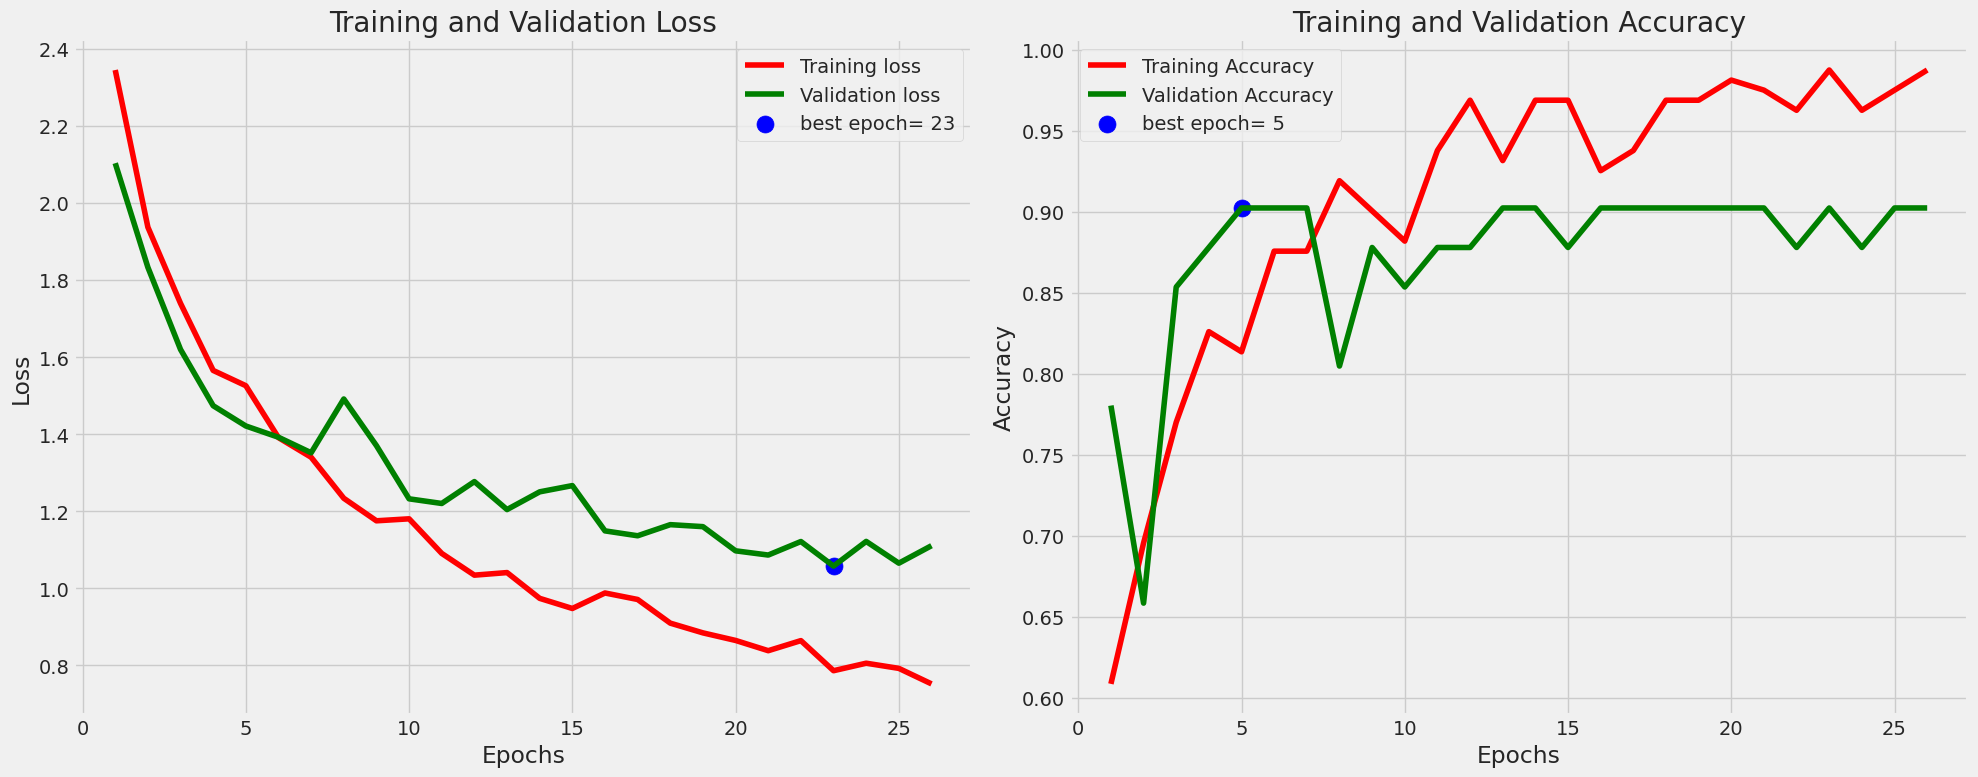

In [66]:
def plot_training_history(history, save_path=None):
    """
    Plots the training history of a model, including training and validation loss, and training and validation accuracy.

    Args:
        history: The training history object returned by the `fit` method of a Keras model.
        save_path (optional): The path to save the plot. If provided, the plot will be saved to the specified location.

    Returns:
        None
    """
    # Define needed variables
    tr_acc = history.history["accuracy"]
    tr_loss = history.history["loss"]
    val_acc = history.history["val_accuracy"]
    val_loss = history.history["val_loss"]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f"best epoch= {str(index_loss + 1)}"
    acc_label = f"best epoch= {str(index_acc + 1)}"

    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use("fivethirtyeight")

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, "r", label="Training loss")
    plt.plot(Epochs, val_loss, "g", label="Validation loss")
    plt.scatter(index_loss + 1, val_lowest, s=150, c="blue", label=loss_label)
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, "r", label="Training Accuracy")
    plt.plot(Epochs, val_acc, "g", label="Validation Accuracy")
    plt.scatter(index_acc + 1, acc_highest, s=150, c="blue", label=acc_label)
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()

    # Save the plot if save_path is not None
    if save_path is not None:
        plt.savefig(save_path)

plot_training_history(history, save_path='/kaggle/working/training_history.png')


Confusion matrix saved as /kaggle/working/confusion_matrix.png


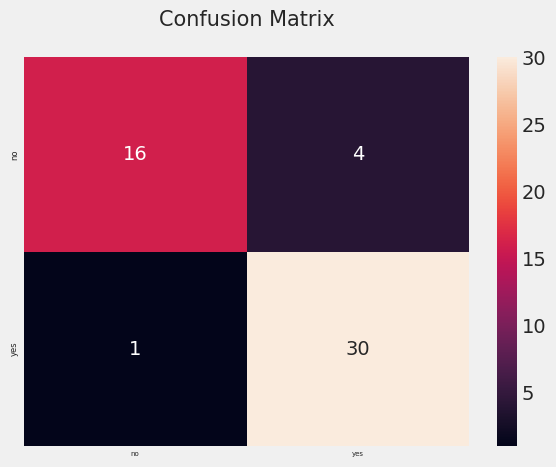

In [67]:
def display_confusion_matrix(y_true, y_pred, save_path=None):
    """
    Display a confusion matrix and save it as an image file if the save_path is not None.

    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
        save_path (str or None): Path to save the confusion matrix image. If None, the image will not be saved.

    Returns:
        None
    """
    cf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure()
    sns.heatmap(cf_matrix, annot=True, xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)), cbar=True)
    plt.title('Confusion Matrix\n', fontsize=15)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=6)

    if save_path is not None:
        plt.savefig(save_path)
        print(f"Confusion matrix saved as {save_path}")
    else:
        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
# Assuming you have the y_test and pred variables defined
save_path = "/kaggle/working/confusion_matrix.png"  # Set the desired save path or set it to None to only display the matrix

display_confusion_matrix(y_test, pred, save_path)

In [68]:
from sklearn.metrics import classification_report

def save_classification_report(y_true, y_pred, save_path=None):
    """
    Print the classification report and save it as a text file if the save_path is not None.

    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
        save_path (str or None): Path to save the classification report. If None, the report will not be saved.

    Returns:
        None
    """
    report = classification_report(y_true, y_pred)

    print(report)

    if save_path is not None:
        with open(save_path, "w") as file:
            file.write(report)
        print(f"Classification report saved as {save_path}")


# Assuming you have the y_test and pred variables defined
save_path = "/kaggle/working/classification_report.txt"  # Set the desired save path or set it to None to only print the report

save_classification_report(y_test, pred, save_path)

              precision    recall  f1-score   support

          no       0.94      0.80      0.86        20
         yes       0.88      0.97      0.92        31

    accuracy                           0.90        51
   macro avg       0.91      0.88      0.89        51
weighted avg       0.91      0.90      0.90        51

Classification report saved as /kaggle/working/classification_report.txt


In [69]:
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'best_model.h5')
model.save(save_path)
print(f'Best model saved at: {save_path}')


Best model saved at: saved_models/best_model.h5
